# not-MIWAE: Deep Generative Modelling with Missing not at Random Data
This notebook illustrates how to fit a *deep latent variable model* to data affected by a missing process which depends on the missing data itself, i.e. *missing not at random*.

We fit a linear PPCA-like model to a relatively small UCI dataset.

### Preamble

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
import tensorflow_probability  as tfp
import keras
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
# import sys
# sys.path.append('./')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['lines.linewidth'] = 2.5

tf.compat.v1.disable_v2_behavior()






Instructions for updating:
non-resource variables are not supported in the long term


### Load data
Here we use the white-wine dataset from the UCI database

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"



### Standardize data

In [3]:
# ---- standardize data
data = np.array(pd.read_csv(url, low_memory=False, sep=';'))
labels_gt = data[:,-1]
data = data[:, :-1]
data = data - np.mean(data, axis=0)
data = data / np.std(data, axis=0)

# Fractionnement en ensembles d'entraînement (train) et de test (test)
Xtrain, Xtest, ytrain,ytest = train_test_split(
    data, labels_gt, test_size=0.05, random_state=42
)

# ---- we use the full dataset for training here, but you can make a train-val split
Xgt= Xtrain.copy() #ground truth for archive
Xval = Xtrain.copy()

### Settings (MIVAE)

In [4]:
N, D = data.shape
n_latent = D - 1
n_hidden = 128
n_samples = 20
max_iter = 100000
batch_size = 16
n_classes = 5

### Settings (Regressor)

In [5]:
n_outputs = 1
n_features = D
learning_rate = 2e-4
n_epochs = 300
n_hidden_units = 128

### Introduce missing 
Here we denote
- Xnan: data matrix with np.nan as the missing entries
- Xz: data matrix with 0 as the missing entries
- S: missing mask 

The missing process depends on the missing data itself:
- in half the features, set the feature value to missing when it is higher than the feature mean

In [6]:
# ---- introduce missing process on trainin set
Xnan = Xtrain.copy()
Xz = Xtrain.copy()

mean = np.mean(Xnan[:, :int(D / 2)], axis=0)
ix_larger_than_mean = Xnan[:, :int(D / 2)] > mean

Xnan[:, :int(D / 2)][ix_larger_than_mean] = np.nan
Xz[:, :int(D / 2)][ix_larger_than_mean] = 0

S = np.array(~np.isnan(Xnan), dtype=np.float32)

# ---- introduce missing process on test set

Xnan_test = Xtest.copy()
Xz_test = Xtest.copy()

mean = np.mean(Xnan_test[:, :int(D / 2)], axis=0)
ix_larger_than_mean = Xnan_test[:, :int(D / 2)] > mean

Xnan_test[:, :int(D / 2)][ix_larger_than_mean] = np.nan
Xz_test[:, :int(D / 2)][ix_larger_than_mean] = 0

S_test = np.array(~np.isnan(Xnan_test), dtype=np.float32)

### Inputs
Let's first define the inputs of the model
- x_pl: data input
- s_pl: mask input
- n_pl: number of importance samples
- X_pl: data input for the regressor
- y_pl: labels input

In [7]:
print("Creating graph...")
tf.reset_default_graph()
# ---- input
with tf.variable_scope('input'):
    x_pl = tf.placeholder(tf.float32, [None, D], 'x_pl')
    s_pl = tf.placeholder(tf.float32, [None, D], 's_pl')
    n_pl = tf.placeholder(tf.int32, shape=(), name='n_pl')
    
    X = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, n_features], name="X")
    y = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, n_outputs], name="y")

Creating graph...


the noise variance is learned as a shared parameter

In [8]:
# ---- parameters
with tf.variable_scope('data_process'):
    logstd = tf.get_variable('logstd', shape=[])

### Encoder
The encoder / inference network consists of two hidden layers with 128 units and tanh activation

In [9]:
x = keras.layers.Dense(units=n_hidden, activation=tf.nn.tanh, name='l_enc1')(x_pl)
x = keras.layers.Dense(units=n_hidden, activation=tf.nn.tanh, name='l_enc2')(x)

q_mu = keras.layers.Dense(units=n_latent, activation=None, name='q_mu')(x)

q_logstd = keras.layers.Dense(units=n_latent, activation=lambda x: tf.clip_by_value(x, -10, 10),
                           name='q_logstd')(x)

### Variational distribution

In [10]:
q_z = tfp.distributions.Normal(loc=q_mu, scale=tf.exp(q_logstd))

# ---- sample the latent value
l_z = q_z.sample(n_pl)                    # shape [n_samples, batch_size, dl]
l_z = tf.transpose(l_z, perm=[1, 0, 2])   # shape [batch_size, n_samples, dl]

### Decoder for features

In [11]:
mu = keras.layers.Dense(units=D, activation=None, name='mu')(l_z)

### Observation model / likelihood function

In [12]:
p_x_given_z = tfp.distributions.Normal(loc=mu, scale=tf.exp(logstd))

### Parameters for Regressor

In [13]:
# Weights and biases for the hidden layer

W_hidden = tf.Variable(tf.random.truncated_normal([n_features, n_hidden_units], stddev=0.1), name="W_hidden")
b_hidden = tf.Variable(tf.zeros([n_hidden_units]), name="b_hidden")

# Hidden layer with ReLU activation function
hidden_layer = tf.nn.relu(tf.matmul(X, W_hidden) + b_hidden)

# Weights and bias for the output layer
W_output = tf.Variable(tf.random.truncated_normal([n_hidden_units, n_outputs], stddev=0.1), name="W_output")
b_output = tf.Variable(tf.zeros([n_outputs]), name="b_output")

# Output layer (no activation function for regression)
y_pred = tf.matmul(hidden_layer, W_output) + b_output

# Loss function: Mean Squared Error (MSE)
loss_MLP = tf.reduce_mean(tf.square(y_pred - y))

### Missing model
- first mix observed data and samples of missing data
- feed through missing model
- find likelihood of missing model parameters

We have to expand the dimensions of x_pl and s_pl, since mu has size [batch, n_samples, D]

In [14]:
l_out_mixed = mu * tf.expand_dims(1 - s_pl, axis=1) + tf.expand_dims(x_pl * s_pl, axis=1)

In [15]:
W = tf.get_variable('W', shape=[1, 1, D])
W = -tf.nn.softplus(W)
b = tf.get_variable('b', shape=[1, 1, D])

logits = W * (l_out_mixed - b)

p_s_given_x = tfp.distributions.Bernoulli(logits=logits)

### Evaluating likelihoods

In [16]:
# ---- evaluate the observed data in p(x|z)
log_p_x_given_z = tf.reduce_sum(tf.expand_dims(s_pl, axis=1) * 
                                p_x_given_z.log_prob(tf.expand_dims(x_pl, axis=1)), axis=-1)  # sum over d-dimension

# --- evaluate the z-samples in q(z|x)
q_z2 = tfp.distributions.Normal(loc=tf.expand_dims(q_z.loc, axis=1), scale=tf.expand_dims(q_z.scale, axis=1))
log_q_z_given_x = tf.reduce_sum(q_z2.log_prob(l_z), axis=-1)

# ---- evaluate the z-samples in the prior p(z)
prior = tfp.distributions.Normal(loc=0.0, scale=1.0)
log_p_z = tf.reduce_sum(prior.log_prob(l_z), axis=-1)

# ---- evaluate the mask in p(s|x)
log_p_s_given_x = tf.reduce_sum(p_s_given_x.log_prob(tf.expand_dims(s_pl, axis=1)), axis=-1)


### Losses for the MIWAE and not-MIWAE respectively

In [17]:
lpxz = log_p_x_given_z
lpz = log_p_z
lqzx = log_q_z_given_x
lpsx = log_p_s_given_x

# ---- MIWAE
# ---- importance weights
l_w = lpxz + lpz - lqzx

# ---- sum over samples
log_sum_w = tf.reduce_logsumexp(l_w, axis=1)

# ---- average over samples
log_avg_weight = log_sum_w - tf.log(tf.cast(n_pl, tf.float32))

# ---- average over minibatch to get the average llh
MIWAE = tf.reduce_mean(log_avg_weight, axis=-1) 


# ---- not-MIWAE
# ---- importance weights
l_w = lpxz + lpsx + lpz - lqzx

# ---- sum over samples
log_sum_w = tf.reduce_logsumexp(l_w, axis=1)

# ---- average over samples
log_avg_weight = log_sum_w - tf.log(tf.cast(n_pl, tf.float32))

# ---- average over minibatch to get the average llh
notMIWAE = tf.reduce_mean(log_avg_weight, axis=-1)


### Training stuff

### Choose wether you want to train the MIWAE or the notMIWAE

In [18]:
# ---- training stuff
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
global_step = tf.Variable(initial_value=0, trainable=False)
optimizer = tf.train.AdamOptimizer()

loss_VAE = -notMIWAE
# loss_VAE = -MIWAE
loss_global = loss_VAE + loss_MLP
tvars = tf.trainable_variables()
train_op = optimizer.minimize(loss_global, global_step=global_step, var_list=tvars) # Global objective

optimizer_ = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_global) #MLP
sess.run(tf.global_variables_initializer())

### Single imputation 

In [19]:
def imputationRMSE(sess, Xorg, Xnan, L):

    N = len(Xorg)
    
    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0
    S = np.array(~np.isnan(Xnan), dtype=np.float32)

    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1)[:, None])
        return e_x / e_x.sum(axis=1)[:, None]

    def imp(xz, s, L):
        _mu, _log_p_x_given_z, _log_p_z, _log_q_z_given_x = sess.run(
            [mu, log_p_x_given_z, log_p_z, log_q_z_given_x],
            {x_pl: xz, s_pl: s, n_pl: L})

        wl = softmax(_log_p_x_given_z + _log_p_z - _log_q_z_given_x)

        xm = np.sum((_mu.T * wl.T).T, axis=1)
        xmix = xz + xm * (1 - s)

        return _mu, wl, xm, xmix

    XM = np.zeros_like(Xorg)
    XMIX = np.zeros_like(Xorg)

    for i in range(N):

        xz = Xz[i, :][None, :]
        s = S[i, :][None, :]

        _mu, wl, xm, xmix = imp(xz, s, L)

        XM[i, :] = xm
        XMIX[i, :]= xmix
        if i % 100 == 0:
            print('{0} / {1}'.format(i, N))
    RMSE = 1

    return RMSE, XM, XMIX


def not_imputationRMSE(sess, Xorg, Xnan, L):
    """
    Function to compute the RMSE of the imputation process and return imputed values.

    Args:
        sess: The TensorFlow session object used to evaluate the model.
        Xorg: The original dataset with no missing values (used for calculating RMSE).
        Xnan: The dataset with missing values to be imputed.
        L: Latent variable or component for the model.

    Returns:
        RMSE: The root mean squared error between the original and imputed datasets.
        XM: The imputed dataset.
    """
    N = len(Xorg)  # Number of samples in the dataset
    
    # Make a copy of the dataset with missing values
    Xz = Xnan.copy()
    
    # Replace NaN values with 0 in the copied dataset
    Xz[np.isnan(Xnan)] = 0
    
    # Create a binary mask indicating where data is missing (1 if not missing, 0 if missing)
    S = np.array(~np.isnan(Xnan), dtype=np.float32)
    
    # Softmax function to normalize weights into probabilities
    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1)[:, None])  # Numerical stability trick
        return e_x / e_x.sum(axis=1)[:, None]  # Normalize by row sum to get probabilities

    # Imputation function that computes the imputed values
    def imp(xz, s, L):
        """
        Performs imputation based on the model's probabilistic outputs.

        Args:
            xz: Input sample with missing values replaced by 0.
            s: Binary mask indicating missing entries.
            L: Latent variable (number of components in the model).

        Returns:
            _mu, wl, xm, xmix: Model's probabilistic outputs and the imputed values.
        """
        # Get model's learned probabilities and mean values by running the session
        _mu, _log_p_x_given_z, _log_p_z, _log_q_z_given_x, _log_p_s_given_x = sess.run(
            [mu, log_p_x_given_z, log_p_z, log_q_z_given_x, log_p_s_given_x],
            {x_pl: xz, s_pl: s, n_pl: L}
        )

        # Compute the softmax weights based on the log-probabilities
        wl = softmax(_log_p_x_given_z + _log_p_s_given_x + _log_p_z - _log_q_z_given_x)

        # Compute the weighted sum of the means (_mu) based on the weights (wl)
        xm = np.sum((_mu.T * wl.T).T, axis=1)
        
        # Final imputed sample: add imputed values (xm) where data was missing
        xmix = xz + xm * (1 - s)

        return _mu, wl, xm, xmix

    # Initialize the imputed dataset (XM) with the same shape as the original dataset
    XM = np.zeros_like(Xorg)
    XMIX = np.zeros_like(Xorg)
    # Loop over all samples in the dataset
    for i in range(N):
        # Extract the current sample (row) from the dataset and its corresponding binary mask
        xz = Xz[i, :][None, :]  # Current sample with missing values
        s = S[i, :][None, :]    # Binary mask indicating missing values
        
        # Call the imputation function to get the imputed values
        _mu, wl, xm, xmix = imp(xz, s, L)

        # Store the imputed values (xm) into the result dataset (XM)
        XM[i, :] = xm
        XMIX[i, :]= xmix
        # Print progress every 100 samples
    RMSE = np.sqrt(np.sum((Xorg - XM) ** 2 * (1 - S)) / np.sum(1 - S)) 

    # Return the computed RMSE and the imputed dataset
    return RMSE, XM, XMIX


### Do the training

In [20]:
batch_pointer = 0

start = time.time()
best = float("inf")
final_losses=np.empty(2)
for epoch in tqdm(range(max_iter), desc=f"Epochs"):
    # Train MIWAE
    N = len(Xz)
    x_train = Xtrain[batch_pointer: batch_pointer + batch_size, :]
    x_batch = Xz[batch_pointer: batch_pointer + batch_size, :]
    s_batch = S[batch_pointer: batch_pointer + batch_size, :]
    x_nan = Xnan[batch_pointer: batch_pointer + batch_size, :]
    y_batch = ytrain[batch_pointer: batch_pointer + batch_size,].reshape(-1, 1)
    x_nan = Xnan[batch_pointer: batch_pointer + batch_size, :]
    rmse, imputations, imputed_matrix = not_imputationRMSE(sess, x_train, x_nan, 1000) #impute and replace 

    X_imp=imputed_matrix
    X_batch = X_imp
    n_samples = X_batch.shape[0]
    sess.run(optimizer_, feed_dict={x_pl: x_batch, s_pl: s_batch, n_pl: n_samples, y:y_batch, X:X_batch})
    batch_pointer += batch_size    


    if batch_pointer > N - batch_size:
        batch_pointer = 0
        p = np.random.permutation(N)
        Xz = Xz[p, :]
        S = S[p, :]
    
    if epoch % 2000 == 0:
        took = time.time() - start
        start = time.time()
        
        # --- change the following batch if you want a true validation set
        x_batch = Xz   
        s_batch = S
        
        final_miwae_loss,final_MLP_loss, _step = sess.run([loss_VAE, loss_MLP,global_step], {x_pl: x_batch, s_pl: s_batch, n_pl: n_samples, y:y_batch, X:X_batch})

        print("{0} updates, {1:.2f} s, {2:.4f} MIWAE train loss , with {3:.4f} RMSE and {4:.4f} MLP loss".format(epoch, took, final_miwae_loss, rmse, final_MLP_loss ))

    if epoch % 2000 == 0:
        predictions = sess.run(y_pred, feed_dict={X: Xtrain})
        predicted_grades = predictions.flatten()  # Flatten to 1D for easy comparison
        ground_truth_grades = ytrain.flatten()  # Flatten ground truth as well
        print(f"Predicted: {predicted_grades[10:15]}, Actual: {ground_truth_grades[10:15]}")

Epochs:   0%|          | 9/100000 [00:00<1:27:46, 18.99it/s] 

0 updates, 0.42 s, 23.9330 MIWAE train loss , with 1.2183 RMSE and 33.1635 MLP loss
Predicted: [ 0.09444977 -0.04253658  0.0782038  -0.00381698 -0.02840996], Actual: [7. 6. 5. 5. 5.]


Epochs:   2%|▏         | 2008/100000 [00:29<27:12, 60.04it/s]

2000 updates, 28.53 s, 17.2564 MIWAE train loss , with 0.9612 RMSE and 0.5366 MLP loss
Predicted: [3.9654477 1.6661773 6.402083  4.5007644 6.067797 ], Actual: [7. 6. 5. 5. 5.]


Epochs:   4%|▍         | 4007/100000 [00:57<21:47, 73.42it/s]

4000 updates, 28.91 s, 15.5307 MIWAE train loss , with 1.5580 RMSE and 0.3042 MLP loss
Predicted: [5.036821  2.826608  5.268067  4.6525493 5.7992887], Actual: [7. 6. 5. 5. 5.]


Epochs:   6%|▌         | 6007/100000 [01:24<20:37, 75.95it/s]

6000 updates, 26.27 s, 14.3795 MIWAE train loss , with 0.8412 RMSE and 0.4475 MLP loss
Predicted: [5.6466384 5.2686434 5.0653954 4.8926206 5.4771757], Actual: [7. 6. 5. 5. 5.]


Epochs:   8%|▊         | 8011/100000 [01:50<20:09, 76.06it/s]

8000 updates, 26.25 s, 13.3811 MIWAE train loss , with 1.6317 RMSE and 0.5767 MLP loss
Predicted: [5.9683275 6.230879  4.9943104 5.141854  5.224989 ], Actual: [7. 6. 5. 5. 5.]


Epochs:  10%|█         | 10012/100000 [02:16<19:26, 77.14it/s]

10000 updates, 26.09 s, 12.5517 MIWAE train loss , with 0.8525 RMSE and 0.3304 MLP loss
Predicted: [6.091729  6.327625  4.8052316 5.284861  5.115516 ], Actual: [7. 6. 5. 5. 5.]


Epochs:  12%|█▏        | 12012/100000 [02:42<19:11, 76.40it/s]

12000 updates, 25.97 s, 11.9343 MIWAE train loss , with 1.2015 RMSE and 0.4623 MLP loss
Predicted: [6.094693  6.2308083 4.9282327 5.2936416 5.117978 ], Actual: [7. 6. 5. 5. 5.]


Epochs:  14%|█▍        | 14012/100000 [03:08<18:52, 75.91it/s]

14000 updates, 25.99 s, 11.4995 MIWAE train loss , with 0.7639 RMSE and 0.1712 MLP loss
Predicted: [6.1247525 6.2787223 4.9301515 5.204816  5.0765624], Actual: [7. 6. 5. 5. 5.]


Epochs:  16%|█▌        | 16012/100000 [03:34<20:11, 69.33it/s]

16000 updates, 26.05 s, 11.3069 MIWAE train loss , with 1.4615 RMSE and 0.3270 MLP loss
Predicted: [6.2068443 6.369111  4.876489  5.2186985 5.1241403], Actual: [7. 6. 5. 5. 5.]


Epochs:  18%|█▊        | 18013/100000 [04:00<17:34, 77.76it/s]

18000 updates, 26.11 s, 11.1526 MIWAE train loss , with 1.9212 RMSE and 0.5998 MLP loss
Predicted: [6.1953807 6.3146205 4.685361  5.2489276 5.0404334], Actual: [7. 6. 5. 5. 5.]


Epochs:  20%|██        | 20014/100000 [04:26<17:11, 77.56it/s]

20000 updates, 26.18 s, 11.0540 MIWAE train loss , with 1.8387 RMSE and 0.1985 MLP loss
Predicted: [6.158644  6.3058586 4.9159255 5.1335673 5.098904 ], Actual: [7. 6. 5. 5. 5.]


Epochs:  22%|██▏       | 22005/100000 [04:53<23:06, 56.27it/s]

22000 updates, 26.38 s, 10.9762 MIWAE train loss , with 0.8148 RMSE and 0.2825 MLP loss
Predicted: [6.2385044 6.4715767 4.8917866 5.0586605 5.1019793], Actual: [7. 6. 5. 5. 5.]


Epochs:  24%|██▍       | 24016/100000 [05:20<16:23, 77.29it/s]

24000 updates, 27.15 s, 10.9167 MIWAE train loss , with 1.6275 RMSE and 0.3366 MLP loss
Predicted: [6.2552814 6.4657793 4.7680874 5.0877657 5.1338215], Actual: [7. 6. 5. 5. 5.]


Epochs:  26%|██▌       | 26014/100000 [05:47<16:06, 76.53it/s]

26000 updates, 26.94 s, 10.9228 MIWAE train loss , with 2.3185 RMSE and 0.2163 MLP loss
Predicted: [6.2085485 6.3316326 4.7635345 5.0944796 5.0878944], Actual: [7. 6. 5. 5. 5.]


Epochs:  28%|██▊       | 28007/100000 [06:16<15:18, 78.38it/s]

28000 updates, 29.18 s, 10.8618 MIWAE train loss , with 0.6725 RMSE and 0.0936 MLP loss
Predicted: [6.229361  6.324962  4.857916  4.94828   5.1236672], Actual: [7. 6. 5. 5. 5.]


Epochs:  30%|███       | 30011/100000 [06:43<15:29, 75.27it/s]

30000 updates, 27.11 s, 10.8573 MIWAE train loss , with 0.7310 RMSE and 0.1751 MLP loss
Predicted: [6.306567  6.404135  4.9120727 4.9267063 5.1970563], Actual: [7. 6. 5. 5. 5.]


Epochs:  32%|███▏      | 32013/100000 [07:10<14:56, 75.87it/s]

32000 updates, 27.30 s, 10.8248 MIWAE train loss , with 0.9308 RMSE and 0.2944 MLP loss
Predicted: [6.3106685 6.3757997 4.706386  4.9657764 5.148827 ], Actual: [7. 6. 5. 5. 5.]


Epochs:  34%|███▍      | 34010/100000 [07:40<14:54, 73.78it/s]

34000 updates, 29.17 s, 10.8148 MIWAE train loss , with 1.1112 RMSE and 0.3002 MLP loss
Predicted: [6.2606564 6.2769003 4.9255285 4.9180775 5.1764555], Actual: [7. 6. 5. 5. 5.]


Epochs:  36%|███▌      | 36009/100000 [08:08<15:18, 69.64it/s]

36000 updates, 28.35 s, 10.7868 MIWAE train loss , with 0.7918 RMSE and 0.0983 MLP loss
Predicted: [6.3068357 6.398028  4.8833003 4.835447  5.166269 ], Actual: [7. 6. 5. 5. 5.]


Epochs:  38%|███▊      | 38012/100000 [08:36<15:05, 68.47it/s]

38000 updates, 27.67 s, 10.7791 MIWAE train loss , with 0.8214 RMSE and 0.6472 MLP loss
Predicted: [6.349539  6.475897  4.835536  4.8486495 5.2272673], Actual: [7. 6. 5. 5. 5.]


Epochs:  40%|████      | 40010/100000 [09:04<15:09, 65.99it/s]

40000 updates, 28.69 s, 10.7583 MIWAE train loss , with 0.6174 RMSE and 0.2836 MLP loss
Predicted: [6.307618  6.3916755 4.6937246 4.8943663 5.1224685], Actual: [7. 6. 5. 5. 5.]


Epochs:  42%|████▏     | 42016/100000 [09:32<12:53, 74.93it/s]

42000 updates, 27.47 s, 10.7411 MIWAE train loss , with 1.3302 RMSE and 0.4815 MLP loss
Predicted: [6.3097835 6.4085627 4.909931  4.745928  5.181507 ], Actual: [7. 6. 5. 5. 5.]


Epochs:  44%|████▍     | 44009/100000 [10:00<14:24, 64.74it/s]

44000 updates, 28.30 s, 10.7240 MIWAE train loss , with 1.2485 RMSE and 0.1877 MLP loss
Predicted: [6.388884  6.5845504 4.94038   4.7354426 5.1955733], Actual: [7. 6. 5. 5. 5.]


Epochs:  46%|████▌     | 46009/100000 [10:27<12:00, 74.97it/s]

46000 updates, 26.98 s, 10.6899 MIWAE train loss , with 0.6643 RMSE and 0.2523 MLP loss
Predicted: [6.382003  6.5878186 4.7582393 4.745445  5.2009416], Actual: [7. 6. 5. 5. 5.]


Epochs:  48%|████▊     | 48010/100000 [10:53<11:29, 75.41it/s]

48000 updates, 25.93 s, 10.6736 MIWAE train loss , with 1.3220 RMSE and 0.1428 MLP loss
Predicted: [6.333285  6.5714025 4.8953424 4.7394533 5.183624 ], Actual: [7. 6. 5. 5. 5.]


Epochs:  50%|█████     | 50010/100000 [11:19<10:37, 78.36it/s]

50000 updates, 26.43 s, 10.6716 MIWAE train loss , with 1.2193 RMSE and 0.2243 MLP loss
Predicted: [6.3719573 6.761465  4.9025493 4.660355  5.159129 ], Actual: [7. 6. 5. 5. 5.]


Epochs:  52%|█████▏    | 52009/100000 [11:47<10:59, 72.80it/s]

52000 updates, 27.12 s, 10.6613 MIWAE train loss , with 0.8758 RMSE and 0.2207 MLP loss
Predicted: [6.4454145 6.9038186 4.9079003 4.6675086 5.2240553], Actual: [7. 6. 5. 5. 5.]


Epochs:  54%|█████▍    | 54008/100000 [12:14<11:24, 67.23it/s]

54000 updates, 27.18 s, 10.6573 MIWAE train loss , with 0.8913 RMSE and 0.1703 MLP loss
Predicted: [6.4605265 6.944747  4.7358866 4.726265  5.1630583], Actual: [7. 6. 5. 5. 5.]


Epochs:  56%|█████▌    | 56010/100000 [12:42<11:05, 66.10it/s]

56000 updates, 28.47 s, 10.6408 MIWAE train loss , with 0.7862 RMSE and 0.2579 MLP loss
Predicted: [6.429158  6.9421406 4.995526  4.6562176 5.192148 ], Actual: [7. 6. 5. 5. 5.]


Epochs:  58%|█████▊    | 58013/100000 [13:12<09:05, 76.94it/s]

58000 updates, 29.70 s, 10.6488 MIWAE train loss , with 0.6461 RMSE and 0.1742 MLP loss
Predicted: [6.498787  7.143197  4.9695625 4.6087446 5.1894064], Actual: [7. 6. 5. 5. 5.]


Epochs:  60%|██████    | 60010/100000 [13:39<08:40, 76.77it/s]

60000 updates, 27.27 s, 10.6370 MIWAE train loss , with 1.3909 RMSE and 0.1549 MLP loss
Predicted: [6.498714  7.1820235 4.8569384 4.6436133 5.2390103], Actual: [7. 6. 5. 5. 5.]


Epochs:  62%|██████▏   | 62014/100000 [14:06<08:20, 75.87it/s]

62000 updates, 26.31 s, 10.6106 MIWAE train loss , with 1.0110 RMSE and 0.2326 MLP loss
Predicted: [6.4566774 7.1027956 4.815694  4.677253  5.16164  ], Actual: [7. 6. 5. 5. 5.]


Epochs:  64%|██████▍   | 64011/100000 [14:31<07:32, 79.55it/s]

64000 updates, 25.77 s, 10.6081 MIWAE train loss , with 0.9681 RMSE and 0.3237 MLP loss
Predicted: [6.4903927 7.1878433 4.9668775 4.5481296 5.1964254], Actual: [7. 6. 5. 5. 5.]


Epochs:  66%|██████▌   | 66010/100000 [14:59<07:13, 78.45it/s]

66000 updates, 27.69 s, 10.5964 MIWAE train loss , with 1.1283 RMSE and 0.1424 MLP loss
Predicted: [6.5410347 7.2977767 5.028463  4.547179  5.2449245], Actual: [7. 6. 5. 5. 5.]


Epochs:  68%|██████▊   | 68013/100000 [15:26<06:52, 77.59it/s]

68000 updates, 26.97 s, 10.6044 MIWAE train loss , with 1.6816 RMSE and 0.3799 MLP loss
Predicted: [6.5212784 7.277078  4.824828  4.566891  5.2174854], Actual: [7. 6. 5. 5. 5.]


Epochs:  70%|███████   | 70010/100000 [15:54<07:52, 63.49it/s]

70000 updates, 28.52 s, 10.5911 MIWAE train loss , with 0.9134 RMSE and 0.2837 MLP loss
Predicted: [6.4813356 7.2136583 5.0302653 4.5543475 5.2263074], Actual: [7. 6. 5. 5. 5.]


Epochs:  72%|███████▏  | 72009/100000 [16:22<06:53, 67.63it/s]

72000 updates, 27.94 s, 10.5669 MIWAE train loss , with 0.9302 RMSE and 0.2892 MLP loss
Predicted: [6.505592  7.2970195 5.0093665 4.513792  5.199245 ], Actual: [7. 6. 5. 5. 5.]


Epochs:  74%|███████▍  | 74012/100000 [16:50<05:31, 78.31it/s]

74000 updates, 27.98 s, 10.5661 MIWAE train loss , with 0.7858 RMSE and 0.1797 MLP loss
Predicted: [6.5219736 7.3719435 4.945138  4.5132194 5.2691026], Actual: [7. 6. 5. 5. 5.]


Epochs:  76%|███████▌  | 76009/100000 [17:17<05:10, 77.24it/s]

76000 updates, 26.20 s, 10.5591 MIWAE train loss , with 0.6744 RMSE and 0.2117 MLP loss
Predicted: [6.4769173 7.2841244 4.798424  4.552093  5.1725545], Actual: [7. 6. 5. 5. 5.]


Epochs:  78%|███████▊  | 78015/100000 [17:43<04:56, 74.26it/s]

78000 updates, 26.02 s, 10.5489 MIWAE train loss , with 2.0714 RMSE and 0.7206 MLP loss
Predicted: [6.470574  7.294607  5.0446777 4.4541097 5.2107487], Actual: [7. 6. 5. 5. 5.]


Epochs:  80%|████████  | 80006/100000 [18:10<04:35, 72.64it/s]

80000 updates, 26.99 s, 10.5656 MIWAE train loss , with 0.9941 RMSE and 0.2285 MLP loss
Predicted: [6.5299544 7.4506135 5.058624  4.434484  5.237394 ], Actual: [7. 6. 5. 5. 5.]


Epochs:  82%|████████▏ | 82007/100000 [18:37<04:28, 66.99it/s]

82000 updates, 27.45 s, 10.5708 MIWAE train loss , with 0.9105 RMSE and 0.1683 MLP loss
Predicted: [6.502457  7.4148135 4.893589  4.4468427 5.2482295], Actual: [7. 6. 5. 5. 5.]


Epochs:  84%|████████▍ | 84010/100000 [19:05<03:54, 68.15it/s]

84000 updates, 28.13 s, 10.5417 MIWAE train loss , with 1.0129 RMSE and 0.1981 MLP loss
Predicted: [6.4253516 7.294553  4.96607   4.467465  5.19983  ], Actual: [7. 6. 5. 5. 5.]


Epochs:  86%|████████▌ | 86010/100000 [19:34<03:38, 63.91it/s]

86000 updates, 28.58 s, 10.5358 MIWAE train loss , with 1.5682 RMSE and 0.2164 MLP loss
Predicted: [6.4597077 7.3756833 5.0299287 4.375012  5.176706 ], Actual: [7. 6. 5. 5. 5.]


Epochs:  88%|████████▊ | 88012/100000 [20:02<02:30, 79.39it/s]

88000 updates, 28.52 s, 10.5425 MIWAE train loss , with 0.8719 RMSE and 0.1416 MLP loss
Predicted: [6.489958  7.464757  5.0597696 4.3742275 5.2545204], Actual: [7. 6. 5. 5. 5.]


Epochs:  90%|█████████ | 90010/100000 [20:29<02:33, 64.90it/s]

90000 updates, 27.16 s, 10.5442 MIWAE train loss , with 1.7750 RMSE and 0.0881 MLP loss
Predicted: [6.4745812 7.4100738 4.8460093 4.4264894 5.1833234], Actual: [7. 6. 5. 5. 5.]


Epochs:  92%|█████████▏| 92009/100000 [20:58<01:44, 76.58it/s]

92000 updates, 28.37 s, 10.5597 MIWAE train loss , with 0.9258 RMSE and 0.3797 MLP loss
Predicted: [6.4284425 7.30394   5.1022363 4.3929634 5.1944823], Actual: [7. 6. 5. 5. 5.]


Epochs:  94%|█████████▍| 94009/100000 [21:25<01:26, 69.02it/s]

94000 updates, 27.52 s, 10.5227 MIWAE train loss , with 0.9486 RMSE and 0.2385 MLP loss
Predicted: [6.4815845 7.454955  5.032355  4.3625035 5.1702614], Actual: [7. 6. 5. 5. 5.]


Epochs:  96%|█████████▌| 96012/100000 [21:54<00:56, 70.93it/s]

96000 updates, 28.97 s, 10.4826 MIWAE train loss , with 0.8878 RMSE and 0.0952 MLP loss
Predicted: [6.455562  7.4800034 4.951222  4.352338  5.2211323], Actual: [7. 6. 5. 5. 5.]


Epochs:  98%|█████████▊| 98013/100000 [22:24<00:25, 78.13it/s]

98000 updates, 29.46 s, 10.5043 MIWAE train loss , with 1.4707 RMSE and 0.1210 MLP loss
Predicted: [6.4065127 7.351228  4.850744  4.394453  5.129599 ], Actual: [7. 6. 5. 5. 5.]


Epochs: 100%|██████████| 100000/100000 [22:51<00:00, 72.91it/s]


### Test time 

In [21]:
final_losses=[(sess.run(loss_VAE, feed_dict={x_pl: x_batch, s_pl: s_batch,n_pl: Xtrain.shape[0], X: Xtrain, y: ytrain.reshape(-1, 1)})),(sess.run(loss_MLP, feed_dict={x_pl: x_batch, s_pl: s_batch,n_pl: Xtrain.shape[0],X: Xtest ,y: ytest.reshape(-1, 1)}))]

In [22]:
print(f"MLP test loss = {final_losses[1]}")


MLP test loss = 0.8149539232254028


### Calculate the single imputation RMSE using 10k importance samples
If you used the MIWAE loss use the imputationRMSE 

If you used the notMIWAE loss use the not_imputationRMSE

In [23]:
# # ---- S has been permuted during training, so just reinstantiate it
S = np.array(~np.isnan(Xnan), dtype=np.float32)
rmse, imputations, imputed_matrix = not_imputationRMSE(sess, Xtrain, Xnan, 1000)
print("imputation train RMSE: ", rmse)
rmse, imputations, imputed_matrix = not_imputationRMSE(sess, Xtest, Xnan_test, 1000)
# rmse, imputations = imputationRMSE(sess, Xtrain, Xnan, 10000)

print("imputation test RMSE: ", rmse)

imputation train RMSE:  1.1730598666881757
imputation test RMSE:  0.9004458176947571


### Compare to missForest and MICE

In [24]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In [25]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(Xnan)
Xrec = imp.transform(Xnan)
rmse_mean = (np.sqrt(np.sum((Xgt - Xrec) ** 2 * (1 - S)) / np.sum(1 - S)))

In [26]:
print("MEAN imputation RMSE: ", rmse_mean)

MEAN imputation RMSE:  1.841474535896206


In [27]:
estimator = RandomForestRegressor(n_estimators=100)
imp = IterativeImputer(estimator=estimator)
imp.fit(Xnan)
Xrec = imp.transform(Xnan)
rmse_mf = np.sqrt(np.sum((Xgt - Xrec) ** 2 * (1 - S)) / np.sum(1 - S))

C:\Users\pipau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [28]:
print("missForst imputation RMSE: ", rmse_mf)

missForst imputation RMSE:  1.6350073230789233


In [29]:
imp = IterativeImputer(max_iter=100)
imp.fit(Xnan)
Xrec = imp.transform(Xnan)
RMSE_iter = np.sqrt(np.sum((Xgt - Xrec) ** 2 * (1 - S)) / np.sum(1 - S))

In [30]:
print("MICE, imputation RMSE", RMSE_iter)

MICE, imputation RMSE 1.682559181194594


### Regressor Quality

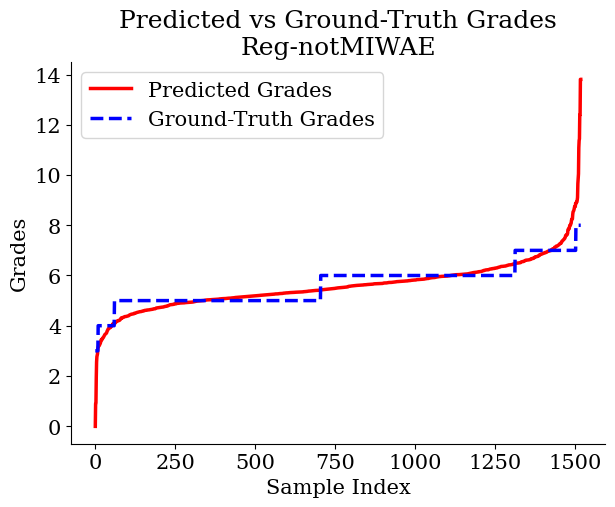

In [ ]:
rmse, imputations, imputed_matrix = not_imputationRMSE(sess, Xtrain, Xnan, 1000)


predictions = sess.run(y_pred, feed_dict={X: Xtrain})
predicted_grades = np.sort(predictions.flatten())  # Flatten to 1D for easy comparison
ground_truth_grades = np.sort(ytrain.flatten())
# print(y_pred.shape())
x_values = range(len(predicted_grades))  # X-axis is just the index of the grades

plt.plot(x_values[:-5], predicted_grades[:-5], c='red', label="Predicted Grades")
plt.plot(x_values[:-5], ground_truth_grades[:-5], c='blue', linestyle='--', label="Ground-Truth Grades")
plt.xlabel("Sample Index")
plt.ylabel("Grades")
plt.tight_layout()
plt.title("Predicted vs Ground-Truth Grades\nReg-notMIWAE")
plt.legend()
plt.show()

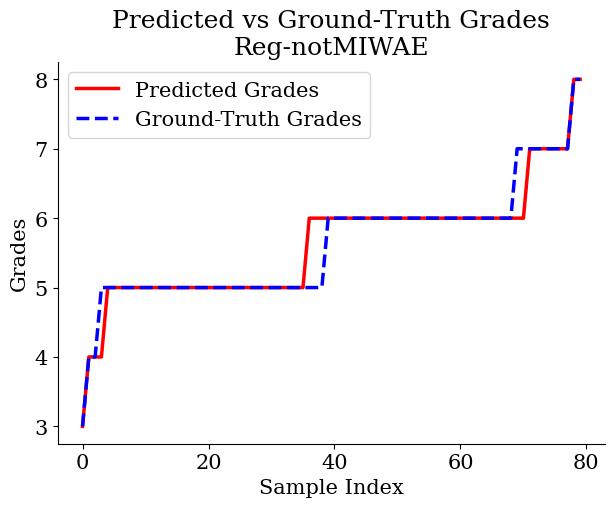

In [32]:

predictions = sess.run(y_pred, feed_dict={X: Xtest})
predicted_grades = np.round(np.sort(predictions.flatten()))  # Flatten to 1D for easy comparison
ground_truth_grades = np.sort(ytest.flatten())
x_values = range(len(predicted_grades))  # X-axis is just the index of the grades
plt.plot(x_values, predicted_grades, c='red', label="Predicted Grades")
plt.plot(x_values, ground_truth_grades, c='blue', linestyle='--', label="Ground-Truth Grades")
plt.xlabel("Sample Index")
plt.ylabel("Grades")
plt.tight_layout()
plt.title("Predicted vs Ground-Truth Grades\nReg-notMIWAE")
plt.legend()
plt.show()

### Classifier


In [33]:
# y_values= labels_gt.copy()
# X_values = imputed_matrix.copy()
# n_outputs = 1
# n_features= X_values.shape[1]
# learning_rate = 3e-4
# n_epochs = 200
# batch_size = 32

In [34]:
# # Placeholders for input and output
# X = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, n_features], name="X")
# y = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, n_outputs], name="y")

# # Define the number of hidden units (you can adjust this number as needed)
# n_hidden_units = 64  # Example number of hidden units

# # Weights and biases for the hidden layer
# W_hidden = tf.Variable(tf.random.truncated_normal([n_features, n_hidden_units], stddev=0.1), name="W_hidden")
# b_hidden = tf.Variable(tf.zeros([n_hidden_units]), name="b_hidden")

# # Hidden layer with ReLU activation function
# hidden_layer = tf.nn.relu(tf.matmul(X, W_hidden) + b_hidden)

# # Weights and bias for the output layer
# W_output = tf.Variable(tf.random.truncated_normal([n_hidden_units, n_outputs], stddev=0.1), name="W_output")
# b_output = tf.Variable(tf.zeros([n_outputs]), name="b_output")

# # Output layer (no activation function for regression)
# y_pred = tf.matmul(hidden_layer, W_output) + b_output

# # Loss function: Mean Squared Error (MSE)
# loss_ = tf.reduce_mean(tf.square(y_pred - y))

# # Optimizer
# optimizer_ = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_)

# # Initialize variables
# init_ = tf.compat.v1.global_variables_initializer()

### Training on inferred data

In [35]:
# data_to_regress_on = [imputed_matrix, Xtrain] # First, test imputed data, then compare to g
# final_losses=np.empty(2)
# with tf.compat.v1.Session() as sess:
#     for l in range(2):
#         X_values=data_to_regress_on[l]
#         print(f"Training n°{l+1}")
#         sess.run(init_)
#         n_samples = X_values.shape[0]
#         for epoch in range(n_epochs):
#             for i in range(0, n_samples, batch_size):
#                 X_batch = X_values[i:i+batch_size]
#                 y_batch = y_values[i:i+batch_size].reshape(-1, 1)  # Ensure correct shape
#                 sess.run(optimizer_, feed_dict={X: X_batch, y: y_batch})

#             if epoch % 50 == 0 or epoch == n_epochs - 1:
#                 current_loss = sess.run(loss_, feed_dict={X: X_values, y: y_values.reshape(-1, 1)})
#                 print(f"Epoch {epoch}, Loss: {current_loss:.4f}")

#         # Final weights and bias
#         final_W_hidden, final_b_hidden, final_W_output, final_b_output = sess.run([W_hidden, b_hidden, W_output, b_output])
#         print("Training complete.")
#         final_losses[l]=(sess.run(loss_, feed_dict={X: X_values, y: y_values.reshape(-1, 1)}))
#         if l == 0:
#             print("Loss with imputed data:", final_losses[l])
#         else :
#             print("Loss with original data:", final_losses[l])
#         # Inference
#         predictions = sess.run(y_pred, feed_dict={X: X_values})

#         # To see the predicted grades alongside the ground truth
#         predicted_grades = predictions.flatten()  # Flatten to 1D for easy comparison
#         ground_truth_grades = y_values.flatten()  # Flatten ground truth as well

#         # Display some predictions alongside their corresponding ground truth
#         for i in range(10, 20):  # Display first 10 samples
#             print(f"Predicted: {predicted_grades[i]}, Actual: {ground_truth_grades[i]}")
#         print('\n')

### Close the session

In [36]:
# sess.close()